In [127]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random


class SineTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, 2*np.pi)
        self.hold_x = None
        
    def sin(self, x):
        return self.amplitude * np.sin(x + self.phase)
    
    def training_data(self, n=10, fresh = False):
        if self.hold_x is None:
            self.hold_x = np.random.uniform(-5, 5, size=(n,1))
            x = self.hold_x
        else:
            if fresh:
                x = np.random.uniform(-5, 5, size=(n,1))
            else:
                x = self.hold_x
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
            
        
    def test_data(self, n=50):
        x = np.linspace(-5, 5, num=n).reshape(n,1)
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
    

class SineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 40)
        self.layer2 = torch.nn.Linear(40, 40)
        self.layer3 = torch.nn.Linear(40, 1)
        self.parameter_dict = {name: par for name, par in self.named_parameters()}
    
    def forward(self, x, parameters=None):
        if parameters is None:
            x = self.layer1(x)
            x = F.relu(x)
            x = self.layer2(x)
            x = F.relu(x)
            x = self.layer3(x)
            return x
        else:
            x = F.linear(x, parameters['layer1.weight'], parameters['layer1.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer2.weight'], parameters['layer2.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer3.weight'], parameters['layer3.bias'])
            return x
    
    def get_parameter_dict(self):
        self.update_parameter_dict()
        return self.parameter_dict
    
    def update_parameter_dict(self):
        self.parameter_dict = {name: par for name, par in self.named_parameters()}

    def copy(self, model):
        self.load_state_dict(model.state_dict())
        
        
class MAML:
    def __init__(self):
        self.meta_model = SineModel()
        self.meta_parameters = self.meta_model.get_parameter_dict()
        self.metric = torch.nn.MSELoss()
        
    def get_parameters(self):
        self.update_meta_parameters()
        return self.meta_parameters
    
    def update_meta_parameters(self):
        self.meta_parameters = self.meta_model.get_parameter_dict()
            
    def train(self, epochs=100, num_tasks=25, num_grad_steps=1, meta_lr=1e-3, step_lr=0.01):
        self.epochs = epochs
        self.num_tasks = num_tasks
        self.meta_lr = meta_lr
        self.step_lr = step_lr
        self.optimizer = torch.optim.Adam(self.meta_model.parameters(), lr=self.meta_lr)
        
        history = []
        self.optimizer.zero_grad()
        
        for epoch in range(epochs):
            
            task_batch_losses = []
            tasks = [SineTask() for m in range(self.num_tasks)]
            for task in tasks:
                
                task_model = SineModel()
                task_model.copy(self.meta_model)
                #hold_parameters = self.meta_parameters
                hold_parameters = self.meta_model.get_parameter_dict()
                for step in range(num_grad_steps):
                    
                    x, y = task.training_data()
                    y_hat = task_model.forward(x, hold_parameters)
                    loss = self.metric(y_hat, y)
                    grads = torch.autograd.grad(loss, hold_parameters.values(), create_graph=True)
                    # update
                    hold_parameters = {name:(parameter - self.step_lr * grad) for ((name, parameter), grad) in zip(hold_parameters.items(), grads)}
        
                x, y = task.training_data(fresh=True)
                y_hat = self.meta_model.forward(x, hold_parameters)
                meta_loss = self.metric(y_hat, y)
                meta_loss.backward(retain_graph=True)
                self.optimizer.step()
                self.optimizer.zero_grad()
                task_batch_losses.append(meta_loss.item())
                self.meta_model.update_parameter_dict()
                #self.update_meta_parameters()
                
            history.append(np.mean(task_batch_losses))
        
        return history
    
    def fine_tune(self, task, num_examples=5, gradient_steps=10):
        self.tuned_model = SineModel()
        self.tuned_model.copy(self.meta_model)
        hist = []
        for step in range(gradient_steps):
            x, y = task.training_data()
            y_hat = self.tuned_model.forward(x)
            loss = self.metric(y_hat, y)
            grads = torch.autograd.grad(loss, self.tuned_model.parameters())
            with torch.no_grad():
                for parameter, grad in zip(self.tuned_model.parameters(), grads):
                    parameter -= self.step_lr * grad
            hist.append(loss.item())
        return hist
                
            
    

In [128]:
import time

epochs=500
num_tasks=25
num_grad_steps=1
meta_lr=1e-3
step_lr=0.01

tst = MAML()

start = time.time()
hist =tst.train(epochs, num_tasks, num_grad_steps, meta_lr, step_lr)
end = time.time()
print(end - start)

16.359391689300537


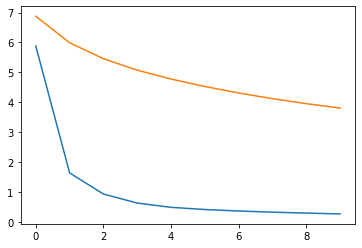

In [135]:
tst2 = MAML()
tst2.train(1, num_tasks, num_grad_steps, meta_lr, step_lr)

task = SineTask()
local = tst.fine_tune(task)
lcl2 = tst2.fine_tune(task)
plt.plot(local)
plt.plot(lcl2)

In [99]:
local

[7.60398006439209,
 5.666747093200684,
 4.650950908660889,
 4.059883117675781,
 3.7725143432617188,
 3.628594160079956,
 3.5719122886657715,
 3.6595406532287598,
 4.142740249633789,
 4.703085422515869]